## Imports

In [122]:
import topopy
from topopy.tests.test_functions import *
import matplotlib.pyplot as plt
import samplers
import seaborn as sns
from matplotlib import patches, collections
import numpy as np
from ipywidgets import interact, widgets

## Setup Variables for Testing

In [32]:
# Look at topopy.tests.test_functions for different examples
test_function = gerber_different_heights

# This is the number of samples per Morse-Smale Complex, as you increase this, you should see less uncertainty in the persistence KDE plot.
samples = 50

## Helper Functions

In [33]:
def validation_grid(resolution=20, min_x = 0, max_x = 1):
    x, y = np.mgrid[min_x:max_x:(resolution * 1j), min_x:max_x:(resolution * 1j)]
    X = np.vstack([x.ravel(), y.ravel()]).T
    return x, y, X

def surface_plot(f, ax, resolution=50, samples=None, edges=None, title=None, cmap=plt.cm.cividis):
    min_x = 0
    max_x = 1
    
    x, y, X = validation_grid(resolution)
    Z = f(X)
    z = Z.reshape(x.shape)
    ax.contourf(x,y,z, cmap=cmap)
    
    if samples is not None:
        ax.scatter(samples[:, 0], samples[:, 1], s=80, linewidth=2, edgecolors="#FFFFFF", facecolors='none', zorder=2)
    if edges is not None:
        lines = []
        for edge in edges:
            lines.append([(samples[edge[0], 0], samples[edge[0], 1]),
                          (samples[edge[1], 0], samples[edge[1], 1])])
        lc = mc.LineCollection(lines, colors="#FFFFFF",
                               linewidths=1, linestyles='--', zorder=1)
        ax.add_collection(lc)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(title, fontsize=18)
    
def f(X):
    X = np.atleast_2d(X)
    Z = np.empty(X.shape[0])
    for i, xi in enumerate(X):
        Z[i] = test_function(xi)
    return Z

## Visualize Function Under Test

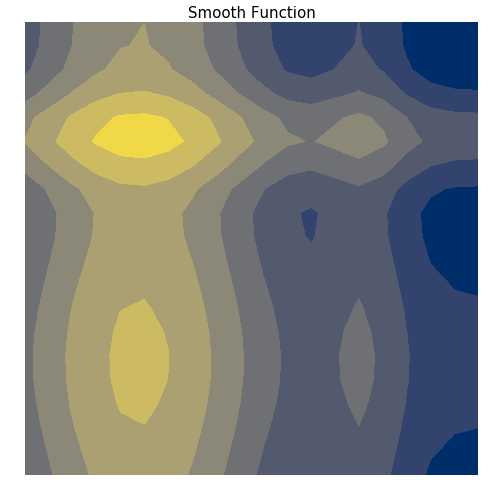

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=60)
surface_plot(f, ax, resolution=20, title='Smooth Function')

## Build Several Complexes Using Random Sampling

In [37]:
def generate_diagrams(samples=samples, repetitions=100):
    diagrams = []

    for seed in range(repetitions):
        X = samplers.CVTSampler.generate_samples(samples, 2, seed)
        Y = test_function(X)
        Y = (Y - np.min(Y)) / (np.max(Y) - np.min(Y))
        msc = topopy.MorseSmaleComplex(graph="beta skeleton", gradient="steepest", max_neighbors=8, beta=1.0)
        msc.build(X, Y)
        dgm = []
        for extrema, (persistence, surviving, saddle) in msc.get_merge_sequence().items():
            extrema_type = msc.get_classification(extrema)
            if extrema_type == 'minimum':
                birth = Y[extrema]
                death = Y[extrema] + persistence
            else:
                birth = Y[extrema] - persistence
                death = Y[extrema]
            dgm.append((birth, death))
        diagrams.append(dgm)
    
    return diagrams

diagrams = generate_diagrams(samples, 100)

## Plot All Realized Persistence Diagrams

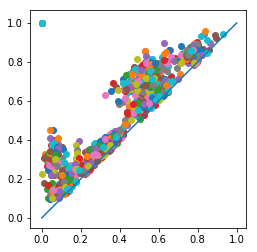

In [38]:
for dgm in diagrams:
    births = []
    deaths = []
    for (birth, death) in dgm:
        births.append(birth)
        deaths.append(death)
    plt.scatter(births, deaths)
plt.plot([0, 1], [0, 1])
plt.gca().set_aspect('equal')

## Some Statistical Plots of All Realized Persistence Diagrams

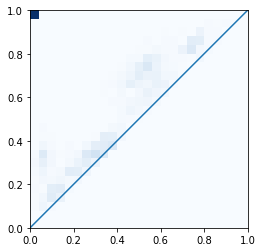

In [36]:
births = []
deaths = []
for dgm in diagrams:
    for (birth, death) in dgm:
        births.append(birth)
        deaths.append(death)

# Should be 0 and 1, respectively
max_value = np.max(np.hstack((births, deaths)))
min_value = np.min(np.hstack((births, deaths)))

plt.hist2d(births, deaths, bins=25, range=[[min_value, max_value], [min_value, max_value]], cmap='Blues')
plt.plot([0, max_value], [0, max_value])
plt.gca().set_xlim(min_value, max_value)
plt.gca().set_ylim(min_value, max_value)
plt.gca().set_aspect('equal')

/home/maljovec/anaconda3/envs/regulus/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


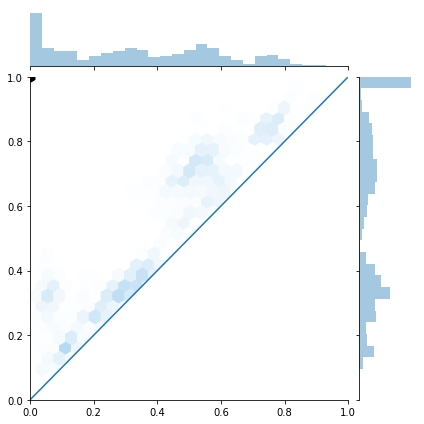

In [8]:
births = []
deaths = []
for dgm in diagrams:
    for (birth, death) in dgm:
        births.append(birth)
        deaths.append(death)

grid = sns.jointplot(births, deaths, joint_kws={"gridsize": 25}, marginal_kws={"bins": 25}, kind="hex", xlim=(min_value, max_value), ylim=(min_value, max_value))
grid.ax_joint.plot([0, max_value], [0, max_value])
lower_triangle = patches.Polygon([[0, 0], [max_value, max_value], [max_value, 0]])
mask = collections.PatchCollection([lower_triangle], alpha=1, color='#FFFFFF')
grid.ax_joint.add_collection(mask)

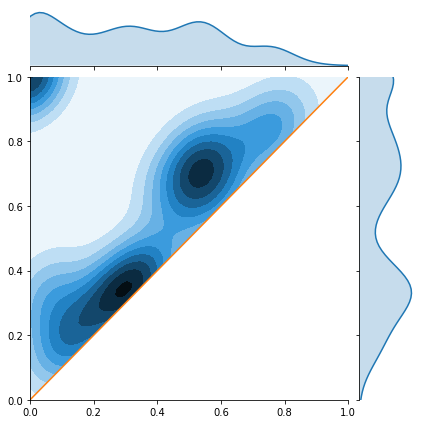

In [9]:
births = []
deaths = []
for dgm in diagrams:
    for (birth, death) in dgm:
        births.append(birth)
        deaths.append(death)

grid = sns.jointplot(births, deaths, kind="kde", xlim=(0, max_value), ylim=(0, max_value))
grid.ax_joint.plot([0, max_value], [0, max_value])
lower_triangle = patches.Polygon([[0, 0], [max_value, max_value], [max_value, 0]])
mask = collections.PatchCollection([lower_triangle], alpha=1, color='#FFFFFF')
grid.ax_joint.add_collection(mask)

## Generate a Ground Truth with Many More Samples

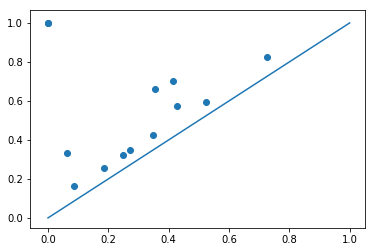

In [11]:
X = samplers.CVTSampler.generate_samples(1000, 2, 0)
Y = test_function(X)
Y = (Y - np.min(Y)) / (np.max(Y) - np.min(Y))
msc = topopy.MorseSmaleComplex(graph="beta skeleton", gradient="steepest", max_neighbors=25, beta=1.0)
msc.build(X, Y)
births = []
deaths = []
for extrema, (persistence, surviving, saddle) in msc.get_merge_sequence().items():
    if persistence > 0.05:
        extrema_type = msc.get_classification(extrema)
        if extrema_type == 'minimum':
            birth = Y[extrema]
            death = Y[extrema] + persistence
        else:
            birth = Y[extrema] - persistence
            death = Y[extrema]

        births.append(birth)
        deaths.append(death)
        
max_value = np.max(np.hstack((births, deaths)))
        
plt.scatter(births, deaths)
plt.plot([0, max_value], [0, max_value])

## Verify the Ground Truth

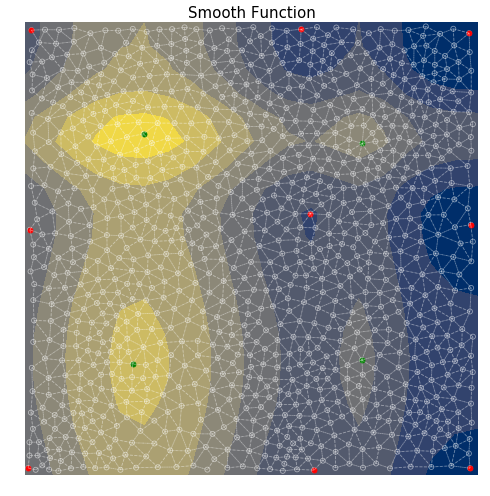

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=60)
surface_plot(f, ax, resolution=20, title='Smooth Function')
maxima = []
minima = []
for extrema, (persistence, surviving, saddle) in msc.get_merge_sequence().items():
    if persistence > 0.05:
        if msc.get_classification(extrema) == 'minimum':
            minima.append(extrema)
        else:
            maxima.append(extrema)
ax.scatter(X[:, 0], X[:, 1], facecolors='none', edgecolors='w', alpha=0.5)
ax.scatter(X[maxima, 0], X[maxima, 1], facecolors='g', edgecolors='g')
ax.scatter(X[minima, 0], X[minima, 1], facecolors='r', edgecolors='r')
lines = []
for i in range(len(Y)):
    neighbors = msc.get_neighbors(i)
    for j in neighbors:
        lines.append([(X[i, 0], X[i, 1]),
                      (X[j, 0], X[j, 1])])

lc = collections.LineCollection(lines, colors="#FFFFFF", linewidths=1, linestyles='--', zorder=1, alpha=0.25)
ax.add_collection(lc)

## Overlay

In [13]:
def plot_overlay(truth, samples=samples, repetitions=100):
    diagrams = generate_diagrams(samples, repetitions)
    births = []
    deaths = []
    for dgm in diagrams:
        for (birth, death) in dgm:
            births.append(birth)
            deaths.append(death)

    grid = sns.jointplot(births, deaths, kind="kde", xlim=(0, max_value), ylim=(0, max_value))
    grid.ax_joint.plot([0, max_value], [0, max_value])
    lower_triangle = patches.Polygon([[0, 0], [max_value, max_value], [max_value, 0]])
    mask = collections.PatchCollection([lower_triangle], alpha=1, color='#FFFFFF')
    grid.ax_joint.add_collection(mask)

    if truth:
        births = []
        deaths = []
        for extrema, (persistence, surviving, saddle) in truth.get_merge_sequence().items():
            if persistence > 0.05:
                extrema_type = msc.get_classification(extrema)
                if extrema_type == 'minimum':
                    birth = Y[extrema]
                    death = Y[extrema] + persistence
                else:
                    birth = Y[extrema] - persistence
                    death = Y[extrema]
                births.append(birth)
                deaths.append(death)
        grid.ax_joint.scatter(births, deaths, c='#FFFFFF', edgecolors='#000000')

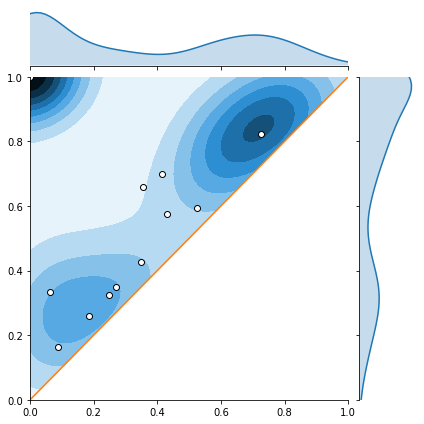

In [14]:
plot_overlay(msc, 20, 100)

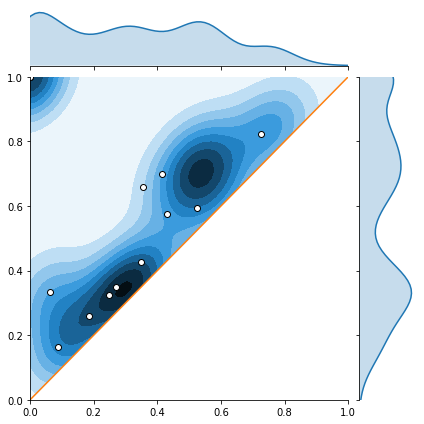

In [15]:
plot_overlay(msc, 50, 100)

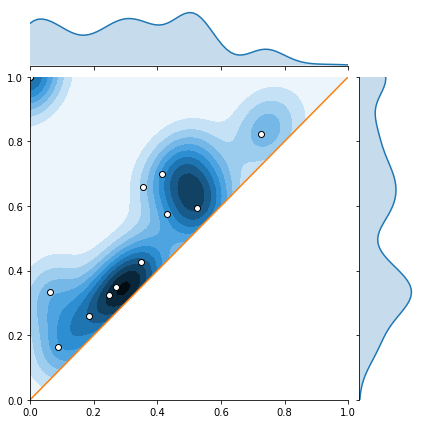

In [16]:
plot_overlay(msc, 100, 100)

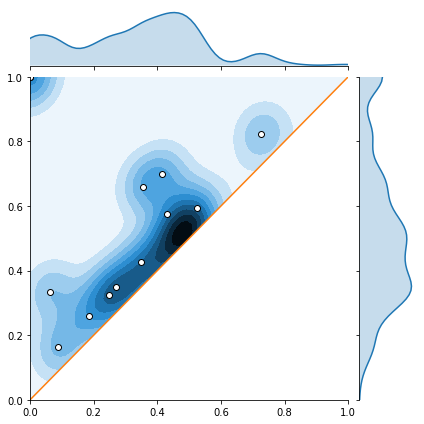

In [17]:
plot_overlay(msc, 1000, 100)

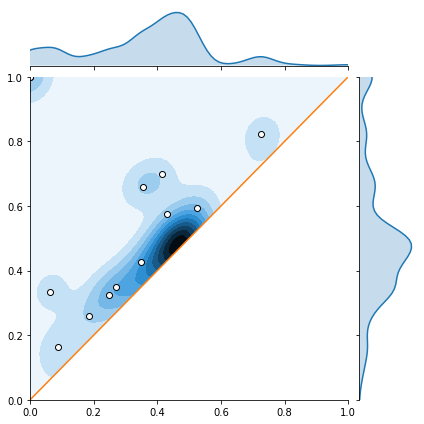

In [18]:
plot_overlay(msc, 5000, 100)

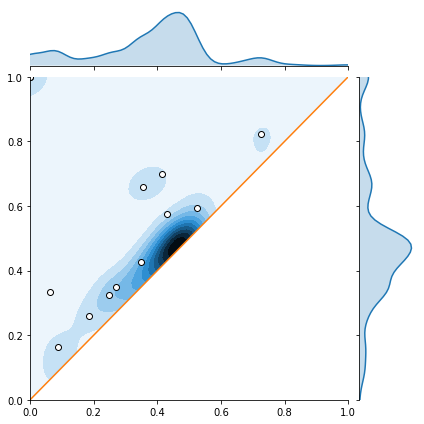

In [19]:
plot_overlay(msc, 10000, 100)

## Probabilistic Graph Function

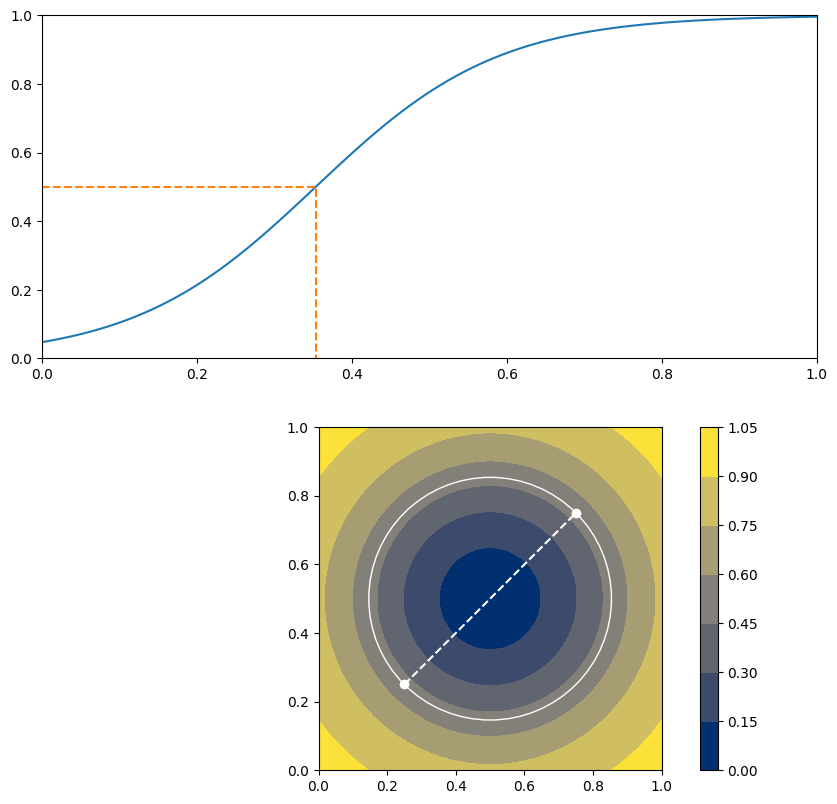

In [118]:
def logistic_function(x, r):
    k = 3. / r
    return 1 / (1 + np.exp(-k*(x - r)))

P = np.array([[0.25, 0.25],[0.75, 0.75]])
mid = np.average(P, axis=0)
r = np.linalg.norm(mid - P[0])

x, y, X = validation_grid(40)
Z = logistic_function(np.linalg.norm(X - mid, axis=1), r)
z = Z.reshape(x.shape)

fig, ax = plt.subplots(2, 1, figsize=(10, 10), dpi=100)
x1 = np.linspace(0, max(2*r,1), 100)
y1 = logistic_function(x1, r)

ax[0].plot(x1, y1)
ax[0].plot([min(x1), r, r], [0.5, 0.5, 0], linestyle='--')
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0, 1)

contour = ax[1].contourf(x,y,z, cmap=plt.cm.cividis, vmin=0, vmax=1)
ax[1].scatter(P[:, 0], P[:, 1], color='#ffffff')
ax[1].plot(P[:, 0], P[:, 1], linestyle='--', color='#ffffff')
empty_region = patches.Circle(mid, r, facecolor='none', edgecolor='#ffffff')
ax[1].add_patch(empty_region)
cb = fig.colorbar(contour, ax=ax[1], boundaries=(0,1))
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 1)
ax[1].set_aspect('equal')

In [127]:
@interact(beta=widgets.FloatSlider(min=0.1, max=2.0, step=0.1, value=1, continuous_update=False),
          lp=widgets.FloatSlider(min=0.1, max=5.0, step=0.1, value=2, continuous_update=False),
          steepness=widgets.FloatSlider(min=1, max=10, step=0.5, value=3, continuous_update=False))
def plot_probability(beta=1, lp=2, steepness=3):
    def paired_lpnorms(A, B, p=2):
        """ Method to compute the paired Lp-norms between two sets of points. Note,
        A and B should be the same shape.

        Args:
            A (MxN matrix): A collection of points
            B (MxN matrix): A collection of points
            p (positive float): The p value specifying what kind of Lp-norm to use
                to compute the shape of the lunes.
        """
        N = A.shape[0]
        dimensionality = A.shape[1]
        norms = np.zeros(N)
        for i in range(N):
            norm = 0.0
            for k in range(dimensionality):
                norm += (A[i, k] - B[i, k])**p
            norms[i] = norm**(1./p)
        return norms


    def min_distance_from_edge(t, beta, p):
        """ Using a parameterized scale from [0,1], this function will determine
        the minimum valid distance to an edge given a specified lune shape defined
        by a beta parameter for defining the radius and a p parameter specifying
        the type of Lp-norm the lune's shape will be defined in.

        Args:
            t (float): the parameter value defining how far into the edge we are.
            0 means we are at one of the endpoints, 1 means we are at the edge's
            midpoint.
            beta (float): The beta value for the lune-based beta-skeleton
            p (float): The p value specifying which Lp-norm to use to compute
                the shape of the lunes. A negative value will be
                used to represent the inf norm

        """
        xC = 0
        yC = 0
        if t > 1:
            return 0
        if beta <= 1:
            r = 1 / beta
            yC = (r**p - 1)**(1. / p)
        else:
            r = beta
            xC = 1 - beta
        y = (r**p - (t-xC)**p)**(1. / p) - yC
        return 0.5*y

    def logistic_function(x, r):
        k = steepness / r
        return 1 / (1 + np.exp(-k*(x - r)))

    P = np.array([[0.25, 0.25],[0.75, 0.75]])
    mid = np.average(P, axis=0)
    r = np.linalg.norm(mid - P[0])

    x, y, X = validation_grid(40)
    Z = logistic_function(np.linalg.norm(X - mid, axis=1), r)
    z = Z.reshape(x.shape)

    p = P[0]
    q = P[1]
    pq = q - p
    edge_length = np.linalg.norm(pq)
    Xp = X - p
    projections = np.dot(Xp, pq)/(edge_length**2)
    # temp_indices = np.logical_and(projections > 0., projections < 1.)
    # valid_indices = np.nonzero(temp_indices)[0]
    valid_indices = np.array(range(len(projections)))

    temp = np.atleast_2d(projections[valid_indices]).T*pq
    min_distances = np.zeros(len(valid_indices))
    for idx, t in enumerate(projections[valid_indices]):
        min_distances[idx] = min_distance_from_edge(abs(2*t-1), beta=beta, p=lp) * edge_length
    distances_to_edge = paired_lpnorms(Xp[valid_indices], temp)

    # distances_to_edge < min_distances

    Z = logistic_function(distances_to_edge, min_distances)
    z = Z.reshape(x.shape)

    fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=80)
    contour = ax.contourf(x,y,z, cmap=plt.cm.cividis, vmin=0, vmax=1)
    ax.scatter(P[:, 0], P[:, 1], color='#ffffff')
    ax.plot(P[:, 0], P[:, 1], linestyle='--', color='#ffffff')
    empty_region = patches.Circle(mid, r, facecolor='none', edgecolor='#ffffff')
    ax.add_patch(empty_region)
    cb = fig.colorbar(contour, ax=ax, boundaries=(0,1))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal')

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='beta', max=2.0, min=0.1), F…